# 1. 데이터 준비

In [43]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection

# 데이터셋 로드
transform = transforms.Compose([
    transforms.ToTensor()          # Tensor로 변환
])

train_dataset = VOCDetection(
    root='./data',  # 다운로드 경로
    year='2012',    # VOC 2012 데이터셋
    image_set='train',
    download=True,
    transform=transform
)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


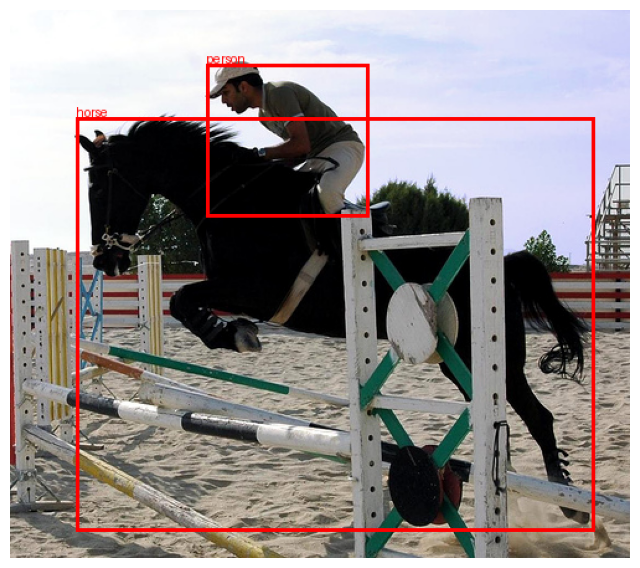

In [97]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# 첫 번째 이미지와 타겟 가져오기
image, target = train_dataset[0]

# 이미지 변환 (Tensor -> PIL Image)
image = transforms.ToPILImage()(image)

# 타겟에서 바운딩 박스와 클래스 정보 추출
annotations = target["annotation"]["object"]

# 바운딩 박스와 클래스 정보 그리기
draw = ImageDraw.Draw(image)

for obj in annotations:
    name = obj["name"]  # 클래스 이름
    bbox = obj["bndbox"]
    xmin, ymin, xmax, ymax = map(int, (bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]))
    
    # 바운딩 박스 그리기
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
    
    # 클래스 이름 추가
    draw.text((xmin, ymin - 10), name, fill="red")

# 시각화
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

# 2. Region Proposal 생성 (Selective Search)

In [98]:
import selectivesearch
import numpy as np

def run_selective_search(image):
    # Selective Search 실행
    numpy_image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    numpy_image = (numpy_image * 255).astype(np.uint8)  # 0-255로 변환
    
    _, regions = selectivesearch.selective_search(numpy_image, scale=500, sigma=0.9, min_size=10)

    proposals = [(r['rect']) for r in regions if r['size'] > 200]
    return proposals

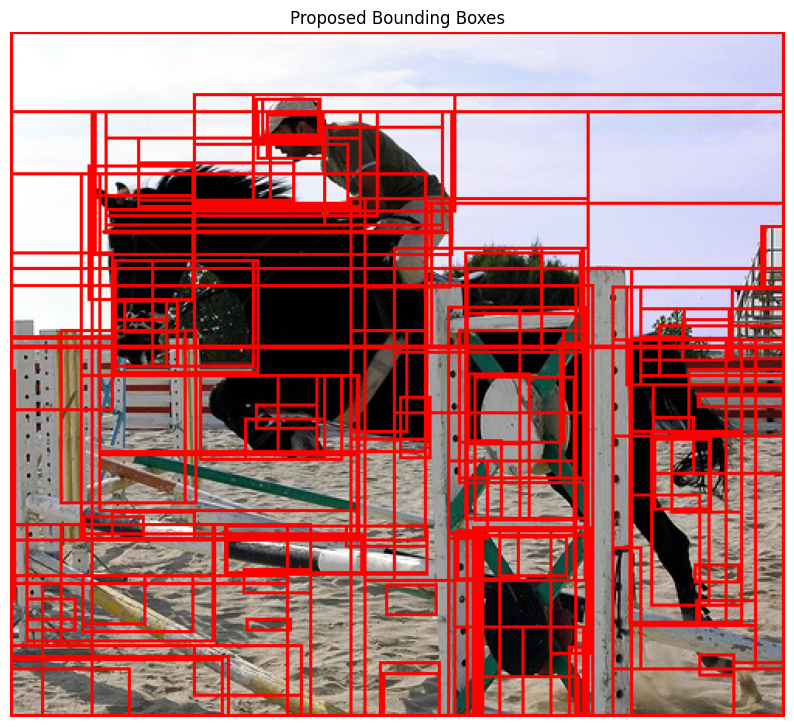

In [99]:
image, target = train_dataset[0]
proposals = run_selective_search(image)
image = transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for (x, y, w, h) in proposals:
    draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.title("Proposed Bounding Boxes")
plt.show()

# 3. Region Proposal 전처리

In [119]:
image, target = train_dataset[0]
proposals = run_selective_search(image)

In [120]:
def preprocess_region(image, region):
    x, y, w, h = region
    cropped_region = image.crop((x, y, x + w, y + h))  # Region Proposal 자르기
    resized_region = cropped_region.resize((224, 224)) # 고정 크기로 리사이즈
    return transforms.ToTensor()(resized_region)       # Tensor 변환

In [121]:
image = transforms.ToPILImage()(image)
for proposal in proposals:
    pre_image = preprocess_region(image, proposal)
    break

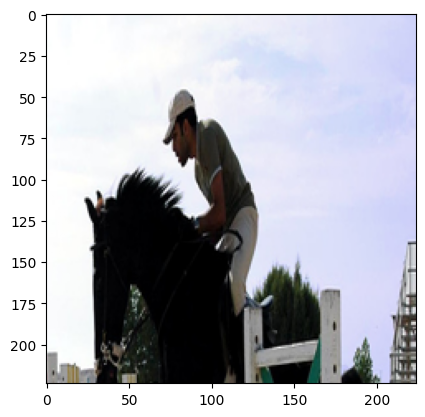

In [122]:
pre_image = pre_image.permute(1, 2, 0).numpy()  # CxHxW -> HxWxC
plt.imshow(pre_image)
plt.show